1. Train the model with Signal(NMSSM) and $\gamma\gamma$+Jets and gJets 

In [2]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# file path
files = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X300_Y60/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X300_Y70/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt40/preselection")
]

In [9]:
keys = [
#     'dibjet_mass',
    # 'diphoton_mass',
    'bbgg_mass',
    'dibjet_pt',
    'diphoton_pt',
    'bbgg_pt',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
    # 'weight_preselection',
    'weight_preselection',
]

In [20]:
dfs = {}

# Loop through each file and load the corresponding dataframe
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")

signal_df_1 = dfs["/NMSSM_X300_Y60/preselection"]
signal_df_2 = dfs["/NMSSM_X300_Y70/preselection"]
background_df_1 = dfs["/GGJets/preselection"]
background_df_2 = dfs["/GJetPt20To40/preselection"]
background_df_3 = dfs["/GJetPt40/preselection"]

print('singal df NMSSM_X300_Y60', signal_df_1.shape)
print('singal df NMSSM_X300_Y70', signal_df_2.shape)
print('background_df_1 ', background_df_1.shape)
print('background_df_2', background_df_2.shape)
print('background_df_3 ', background_df_3.shape)

background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
print('background_df', background_df.shape)

signal_df_1['label'] = 1
signal_df_2['label'] = 2
background_df['label'] = 0

combined_df = pd.concat([signal_df_1, signal_df_2, background_df], ignore_index=True)
print('combined dataframe', combined_df.shape)

features = [
    # 'diphoton_mass',
#     'dibjet_mass',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'bbgg_mass',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
]

singal df NMSSM_X300_Y60 (14779, 33)
singal df NMSSM_X300_Y70 (15394, 33)
background_df_1  (46802, 33)
background_df_2 (9867, 33)
background_df_3  (41966, 33)
background_df (98635, 33)
combined dataframe (128808, 34)


In [21]:
X = combined_df[features]
y = combined_df['label']
weight = combined_df['weight_preselection']
print(weight.shape)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])

(128808,)


In [22]:
# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

class SimpleDNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)  # Output layer for n_classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits for each class
        return x

criterion = nn.CrossEntropyLoss(reduction='mean')  # Use 'mean' for standard loss computation

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels, weights in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects raw logits
            
            if weights is not None:  # Apply weights if provided
                weighted_loss = (loss * weights).mean()
            else:
                weighted_loss = loss.mean()
            
            weighted_loss.backward()
            optimizer.step()
            
            running_loss += weighted_loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    return epoch_losses, epoch_accuracies

def evaluate_model(model, test_loader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels, _ in test_loader:  # Assuming weights are not needed for evaluation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Background", "Signal 1", "Signal 2"]))
    
    return accuracy


In [44]:
# Define the number of classes and input dimensions
n_classes = 3  # Three classes: Background, Signal 1, Signal 2
input_dim = X_train_scaled.shape[1]  # Number of features in your input data

# Instantiate the model
model = SimpleDNN(input_dim, n_classes)

# Define the loss function (reduction='none' if you are using sample weights)
criterion = nn.CrossEntropyLoss(reduction='none')

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and get losses and accuracies
losses, accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)  # Adjust num_epochs as needed


Epoch 1/20, Loss: 0.0000, Accuracy: 0.5091
Epoch 2/20, Loss: 0.0000, Accuracy: 0.5875
Epoch 3/20, Loss: 0.0000, Accuracy: 0.5932
Epoch 4/20, Loss: 0.0000, Accuracy: 0.6024
Epoch 5/20, Loss: 0.0000, Accuracy: 0.6039
Epoch 6/20, Loss: 0.0000, Accuracy: 0.6106
Epoch 7/20, Loss: 0.0000, Accuracy: 0.6104
Epoch 8/20, Loss: 0.0000, Accuracy: 0.6148
Epoch 9/20, Loss: 0.0000, Accuracy: 0.6154
Epoch 10/20, Loss: 0.0000, Accuracy: 0.6199
Epoch 11/20, Loss: 0.0000, Accuracy: 0.6210
Epoch 12/20, Loss: 0.0000, Accuracy: 0.6179
Epoch 13/20, Loss: 0.0000, Accuracy: 0.6224
Epoch 14/20, Loss: 0.0000, Accuracy: 0.6281
Epoch 15/20, Loss: 0.0000, Accuracy: 0.6244
Epoch 16/20, Loss: 0.0000, Accuracy: 0.6271
Epoch 17/20, Loss: 0.0000, Accuracy: 0.6303
Epoch 18/20, Loss: 0.0000, Accuracy: 0.6320
Epoch 19/20, Loss: 0.0000, Accuracy: 0.6293
Epoch 20/20, Loss: 0.0000, Accuracy: 0.6323


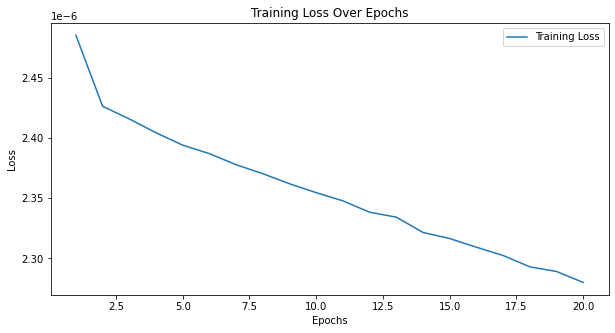

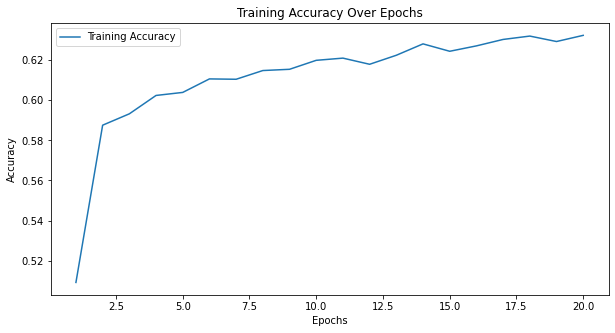

In [45]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()


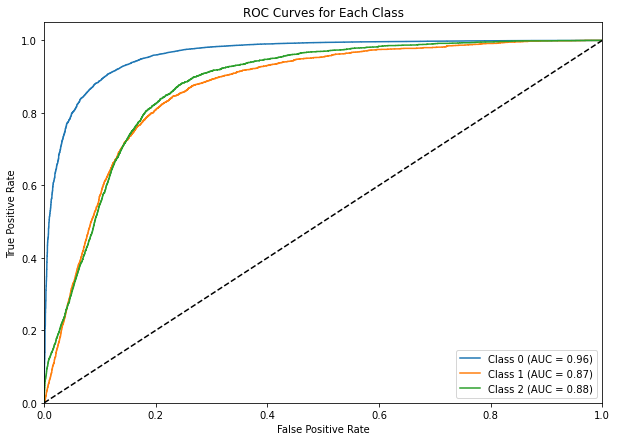

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC calculation (one-vs-rest)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Predict probabilities on the test set
model.eval()
y_score = []
with torch.no_grad():
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        y_score.extend(outputs.numpy())

y_score = np.array(y_score)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


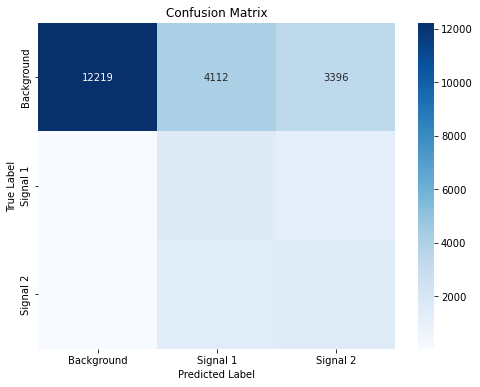

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = []
with torch.no_grad():
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Signal 1", "Signal 2"], yticklabels=["Background", "Signal 1", "Signal 2"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Classifier output 

In [48]:
# Get classifier outputs for training and testing data
model.eval()
train_outputs = []
test_outputs = []

with torch.no_grad():
    for inputs, _, _ in train_loader:
        outputs = model(inputs)
        train_outputs.extend(outputs.numpy())
    
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        test_outputs.extend(outputs.numpy())

train_outputs = np.array(train_outputs)
test_outputs = np.array(test_outputs)


ValueError: The 'color' keyword argument must have one color per dataset, but 3 datasets and 1 colors were provided

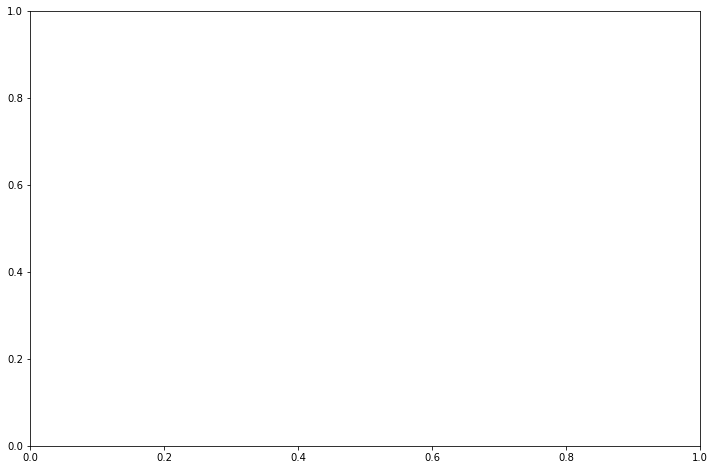

In [49]:
import matplotlib.pyplot as plt

# Assuming binary classification, extract signal and background
train_signal_output = train_outputs[y_train == 1]
train_background_output = train_outputs[y_train == 0]

test_signal_output = test_outputs[y_test == 1]
test_background_output = test_outputs[y_test == 0]

# Plot
plt.figure(figsize=(12, 8))

# Histogram for training data
plt.hist(train_signal_output, bins=50, alpha=0.5, density=True, color='blue', label='Signal (Train)', range=(0, 1), histtype='stepfilled')
plt.hist(train_background_output, bins=50, alpha=0.5, density=True, color='red', label='Background (Train)', range=(0, 1), histtype='stepfilled')

# Overlay test data
plt.hist(test_signal_output, bins=50, alpha=0.5, density=True, color='blue', linestyle='--', label='Signal (Test)', range=(0, 1), histtype='step', linewidth=2)
plt.hist(test_background_output, bins=50, alpha=0.5, density=True, color='red', linestyle='--', label='Background (Test)', range=(0, 1), histtype='step', linewidth=2)

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.title('Classifier Output with PyTorch')
plt.legend()
plt.show()
